In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, cv2
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm      # a nice pretty percentage bar for tasks.
from random import shuffle

In [3]:
TRAIN_DIR = '../input/train/'
TRAIN_DIR_DOG = '../input/train/dog/' 
TRAIN_DIR_CAT = '../input/train/cat/'

VAL_DIR = '../input/validation/'
VAL_DIR_DOG = '../input/validation/dog/'
VAL_DIR_CAT = '../input/validation/cat/'

TEST_DIR = '../input/test/'

ROWS = 128
COLS = 128
CHANNELS = 1
RETRAIN = True

data_dict = {}

dog_train_list = [TRAIN_DIR_DOG+name for i,name in \
                  enumerate(os.listdir(TRAIN_DIR_DOG))]
cat_train_list = [TRAIN_DIR_CAT+name for i,name in \
                  enumerate(os.listdir(TRAIN_DIR_CAT))]

TRAIN_COUNT = len(dog_train_list) + len(cat_train_list)


data_dict['train_data_files'] = dog_train_list + cat_train_list
data_dict['train_labels'] = [1]*int(TRAIN_COUNT/2) + [0]*int(TRAIN_COUNT/2)

dog_val_list = [VAL_DIR_DOG+name for i, name in \
                enumerate(os.listdir(VAL_DIR_DOG))]
cat_val_list = [VAL_DIR_CAT+name for i, name in \
                enumerate(os.listdir(VAL_DIR_CAT))]

VAL_COUNT = len(dog_val_list) + len(cat_val_list)

data_dict['val_data_files'] = dog_val_list + cat_val_list
data_dict['val_labels']= [1]*int(VAL_COUNT/2) + [0]*int(VAL_COUNT/2)

data_dict['all_data_files'] = data_dict['val_data_files'] + data_dict['train_data_files']
data_dict['all_labels'] = data_dict['val_labels'] + data_dict['train_labels']

TOTAL_COUNT = len(data_dict['all_data_files'])

print('Total image count: {}'.format(len(data_dict['all_data_files'])))


Total image count: 25000


In [4]:
def load_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
#     b,g,r = cv2.split(img)
#     rgb_img = cv2.merge([r,g,b])
    return cv2.resize(img, (ROWS,COLS))
    

def load_image_list(file_list):
    count = len(file_list)
    data = np.ndarray((count, ROWS, COLS, CHANNELS),\
                      dtype=np.uint8)
    for i, image_name in tqdm(enumerate(file_list)):
        data[i] = np.expand_dims(load_image(image_name), axis=2)
    return data #/ 255.0

data_dict['all_data'] = load_image_list(\
                            data_dict['all_data_files'])

print('data_dict shape: {}'.format(data_dict['all_data'].shape))

25000it [01:18, 319.81it/s]


data_dict shape: (25000, 128, 128, 1)


In [6]:
datagen_train = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
     zoom_range = 0.1,
#     rescale=1./255
    )

datagen_val = datagen_train = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
#     rescale=1./255
    )
    
# datagen_train.fit(data_dict['train_data'], augment=True)
# datagen_train.fit(data_dict['val_data'], augment=False)

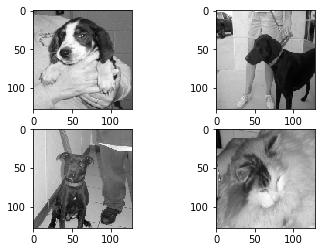

In [7]:
f, axarr = plt.subplots(2,2)
# axarr[0,0].set_title(data_dict['all_data'][0])
axarr[0,0].imshow(np.squeeze(data_dict['all_data'][0], axis=2), cmap='gray')

# axarr[1,0].set_title(data_dict['all_data'][TOTAL_COUNT-1])
axarr[1,0].imshow(np.squeeze(data_dict['all_data'][int(TOTAL_COUNT/2)-1], axis=2), cmap='gray')

# axarr[0,1].set_title(data_dict['all_data'][TOTAL_COUNT])
axarr[0,1].imshow(np.squeeze(data_dict['all_data'][int(TOTAL_COUNT/2) + 2], axis=2), cmap='gray')

# axarr[1,1].set_title(data_dict['all_data'][TOTAL_COUNT*2 -1])
axarr[1,1].imshow(np.squeeze(data_dict['all_data'][TOTAL_COUNT -1], axis=2), cmap='gray')
plt.show()

In [8]:
model = Sequential()
model.add(Conv2D(filters=4, kernel_size=(4,4),\
                 padding='Same', activation='relu',\
                 input_shape=(ROWS,COLS,CHANNELS)))
model.add(Conv2D(filters=8, kernel_size=(4,4),\
                 padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=16, kernel_size=(8,8),\
                 padding='Same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(8,8),\
                 padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(8**2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = SGD(lr=0.03)
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 4)       68        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        8208      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        32800     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
__________

In [16]:
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.save_weights('initial.h5')

filepath='cat_dog_v4a1'

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=False,
                             mode='min')

epochs = 80

kfold = StratifiedKFold(n_splits = 10, shuffle=True)
history_list = []
for train, test in kfold.split(data_dict['all_data'], data_dict['all_labels']):
    model.load_weights('initial.h5')
    datagen_train.fit(data_dict['all_data'][train], augment=True)
    datagen_val.fit(data_dict['all_data'][test], augment=False)
    
    history = model.fit_generator(generator=datagen_train.flow(
                      data_dict['all_data'][train],np.asarray(data_dict['all_labels'])[train]
                  ),
                  epochs=epochs,
                  verbose=2,
                  validation_data=datagen_val.flow(data_dict['all_data'][test]\
                                                   ,np.asarray(data_dict['all_labels'])[test]),
                  callbacks=[checkpoint])
    
    history_list.append(history)
                           


Epoch 1/80


KeyboardInterrupt: 

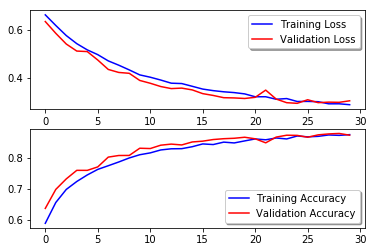

In [9]:
fig, ax = plt.subplots(2,1)
# Loss Plot
for history in history_list
    ax[0].plot(history.history['loss'], color='b', label="Training Loss")
    ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss')

legend = ax[0].legend(loc='best', shadow=True)

# Accuracy Plot
ax[1].plot(history.history['acc'], color='b', label='Training Accuracy')
ax[1].plot(history.history['val_acc'], color='r', label='Validation Accuracy')
legend = ax[1].legend(loc='best', shadow=True)

In [10]:
test_image_list = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

datagen_test = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1./255)

test_set = load_image_list(test_image_list)
datagen_test.fit(test_set)

12500it [00:16, 766.17it/s]


In [12]:
with open('submission_file2.csv','w') as f:
    f.write('id,label\n')
with open('submission_file2.csv','a') as f:
#     test_set = load_image_list(test_image_list)
    print('Evaluate the test set..')
    prediction = model.predict_generator(datagen_test.flow(test_set), steps=391)
    print('Writing the prediction in the submition file..')
    for i, image_file in tqdm(enumerate(prediction)):
        f.write('{},{}\n'.format(i+1, prediction[i][0]))

Evaluate the test set..
Writing the prediction in the submition file..


12500it [00:00, 148911.61it/s]
